In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from requests import get
from bs4 import BeautifulSoup
from urllib.request import urlopen
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

**Define Foursquare Credentials and Version**

In [3]:
# Define Foursquare Credentials and Version

CLIENT_ID ='G1MNQV2BAQP2Y5Q3PI1HPXWO3H4MC4B3ILXS3YOVQ53BETIR'
CLIENT_SECRET='O1EJR4MEXOBGT0X2S210IZFIYFVRG2FCMGDE1FNPX5NMX325'
VERSION='20180605' # Foursquare API version

**define the functionsin this chinese restaurant project**

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

**Get initial NYC data**

In [5]:
#use the above codes to get our initial NYC data
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data.shape

(306, 4)

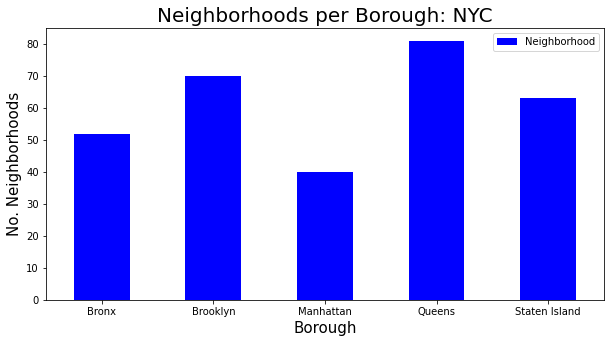

In [7]:
#Initial Data Analysis
clr = "BLUE"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

**Check how many Chinese restaurants there are in each neighborhood and borough.**

In [10]:
# prepare neighborhood list that contains chinese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chinese_restaurants)))
    print(row)
    for resturant_detail in chinese_restaurants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 1 / 306 ) Chinese Restaurants in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 1 / 306 ) Chinese Restaurants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 1 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 1 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 1 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 1 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 1 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 1 / 306 ) Chinese Restaurants in Norwood, Bronx:0
['

In [11]:
#chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv')

In [12]:
chinese_ny = pd.read_csv('chinese_rest_ny_tocsv1.csv')
chinese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
166,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
167,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
168,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant
169,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food
170,Staten Island,Fox Hills,4ef4bbede300e92ba02a52db,New pheonix


In [13]:
chinese_rest_ny.shape

(171, 4)

**We got 171 Chinese Restaurants across the New York City.As we see below, although Manhattan has the least number of neighborhoods, it has a lot of Chinese restaurants. Brooklyn has the most Chinese restaurants, followed by Queens. From the “Chinese Restaurants per Neighborhood” chart, we can see that Chinatown has the most Chinese restaurants, and Chinatown is located in Manhattan.**


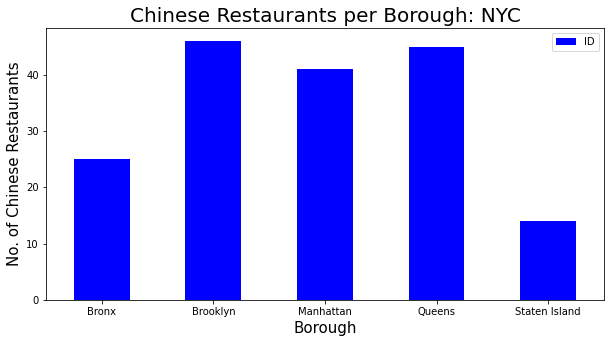

In [16]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

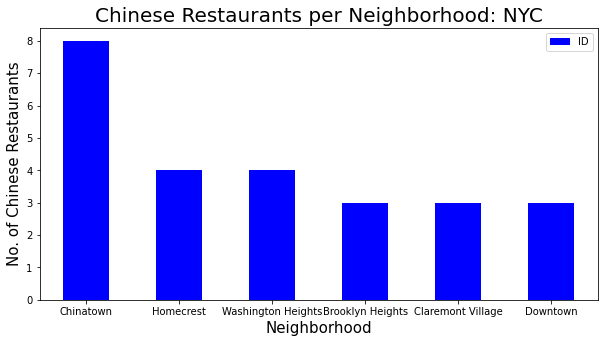

In [15]:
NOofNeigh = 6 # top number for graphing all the same past 6
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [18]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
53,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
54,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店
55,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
56,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
57,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
58,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
59,Manhattan,Chinatown,4afff2b4f964a520583a22e3,Sun Hing Lung Ho Fun Tofu
60,Manhattan,Chinatown,5ff9e5215b3abd71536c9b46,Hay Hay Roasted 囍燒臘


**Therefore, Chinatown in Manhattan has the most Chinese restaurants, with a total of 8 restaurants.Now we get the ranking of each restaurant through the code. We will conduct follow-up analysis after obtaining the ranking.**

In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60eec9c82222750a72f704be'}, 'response': {'venue': {'id': '4c9d5f2654c8a1cd2e71834b', 'name': 'Guang Hui Chinese Restaurant', 'contact': {'phone': '7188623288', 'formattedPhone': '(718) 862-3288'}, 'location': {'address': '125 Dreiser Loop', 'lat': 40.876651, 'lng': -73.829092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.876651, 'lng': -73.829092}, {'label': 'entrance', 'lat': 40.876084, 'lng': -73.829209}], 'postalCode': '10475', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 Dreiser Loop', 'Bronx, NY 10475', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/guang-hui-chinese-restaurant/4c9d5f2654c8a1cd2e71834b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

KeyError: 'venue'

In [21]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [22]:
chinese_rest_stats_ny.shape

(50, 7)

In [23]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       50 non-null     object
 1   Neighborhood  50 non-null     object
 2   ID            50 non-null     object
 3   Name          50 non-null     object
 4   Likes         50 non-null     object
 5   Rating        50 non-null     object
 6   Tips          50 non-null     object
dtypes: object(7)
memory usage: 2.9+ KB


In [24]:
chinese_rest_stats_ny['Likes'] = chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips'] = chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     object 
 6   Tips          50 non-null     float64
dtypes: float64(2), object(5)
memory usage: 2.9+ KB


**continue futher analysis**

In [25]:
# continue futher analysis
chinese_rest_stats_ny.describe()

,Likes,Tips
count,50.00000,50.000000
mean,17.58000,8.780000
std,53.22616,17.730741
min,0.00000,0.000000
25%,0.00000,0.000000
50%,1.00000,0.000000
75%,9.00000,8.750000
max,363.00000,78.000000


In [26]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              58df00318cfe546addb99246
Name                  Birds of a Feather
Likes                                363
Rating                               9.1
Tips                                  78
Name: 48, dtype: object

In [28]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              58df00318cfe546addb99246
Name                  Birds of a Feather
Likes                                363
Rating                               9.1
Tips                                  78
Name: 48, dtype: object

In [40]:
# top 10 neighborhoods with the highest average ratings of chinese restaurants.
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Likes']]
ny_neighborhood_stats.columns=['Neighborhood','Average Likes']
ny_neighborhood_stats.sort_values(['Average Likes'],ascending=False).head(10)

,Neighborhood,Average Likes
28,North Side,363.000000
31,Park Slope,75.000000
9,Clinton Hill,46.000000
36,South Side,41.000000
39,Windsor Terrace,33.500000
14,Downtown,33.333333
22,Gowanus,30.000000
4,Boerum Hill,28.000000
5,Brooklyn Heights,24.666667
34,Pelham Parkway,10.000000


In [42]:
#average likes of chinese Restaurants for each Borough
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Likes']]
ny_borough_stats.columns=['Borough','Average Likes']
ny_borough_stats.sort_values(['Average Likes'],ascending=False).head()

,Borough,Average Likes
1,Brooklyn,27.225806
0,Bronx,1.842105


**visualize the results**

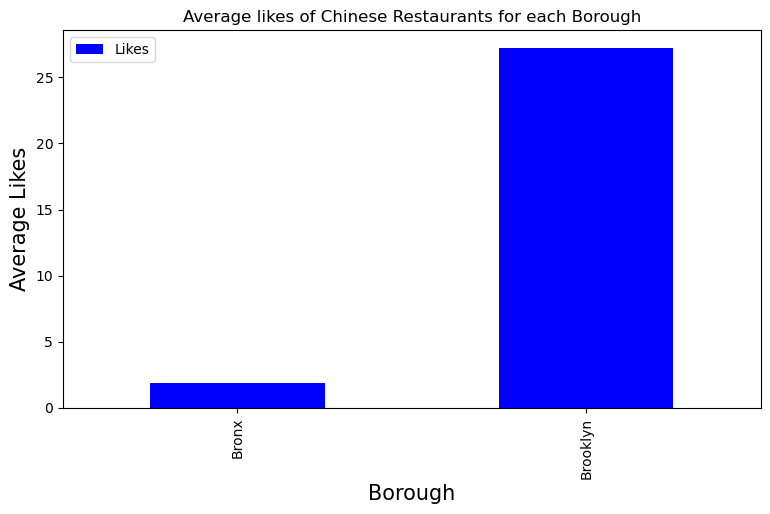

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average likes of Chinese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Likes', fontsize=15)
chinese_rest_stats_ny.groupby('Borough').mean()['Likes'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

**We will consider all the neighborhoods with average likes greater or equal 30.0 to visualize on a map**

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Likes']>=30.0]
ny_neighborhood_stats

,Neighborhood,Average Likes
9,Clinton Hill,46.000000
14,Downtown,33.333333
22,Gowanus,30.000000
28,North Side,363.000000
31,Park Slope,75.000000
36,South Side,41.000000
39,Windsor Terrace,33.500000


In [49]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

## Conclusion:
**All the above analysis depends on the accuracy of Four Square data. More comprehensive analysis and future work need to incorporate data from other external databases. Through our various analyses above, we can draw conclusions. Among the Chinese restaurants in New York, Chinese restaurants in Manhattan and Brooklyn are highly liked on average. at the same time，We got 171 Chinese Restaurants across New York City. From a borough perspective，as we see below, although Manhattan has the least number of neighborhoods(Neighborhoods per Borough: NYC), it has a lot of Chinese restaurants. Brooklyn has the most Chinese restaurants, followed by Queens. From the “Chinese Restaurants per Neighborhood” chart, we can see that Chinatown has the most Chinese restaurants, and Chinatown is located in Manhattan.**

**Based on the above information, I would like to say that Manhattan and Brooklyn are the best places to eat Chinese food in New York. To get the most benefit, I will open a Chinese restaurant in Brooklyn. Brooklyn has multiple neighborhoods, and the average customer love rate exceeds 30. At the same time, the concentration of Chinese restaurants is less than that of Manhattan's Chinatown. Therefore, opening a Chinese restaurant in Brooklyn is less competitive than opening a Chinese restaurant in Chinatown. It is also very important that real estate prices in Brooklyn are much cheaper than in Manhattan, so the rent and cost of opening a restaurant will be lower than in Chinatown in Manhattan. In summary, my Chinese restaurant will be opened in Brooklyn.**